<a href="https://colab.research.google.com/github/nsp8/HexGridGenerator/blob/master/HexGridGeneratorNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HexGrid Generator
## Create hexagonal maps representing countries of the world by reading files from your Google Drive

---
Note: In your Google Drive, under ***My Drive***, create a folder **World HexGrid** and in that - an ***Input*** and an ***Output*** folder. Store all your files that need to be processed in the ***Input*** folder.

### Install all the required packages

In [1]:
!pip install geojson geopandas

     |████████████████████████████████| 901kB 4.3MB/s 
     |████████████████████████████████| 9.8MB 31kB/s 
     |████████████████████████████████| 17.9MB 30.2MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=e0ba9406b2b4f240f80760e20805061268e420aba39245e35f71655b66870f8d
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


### Enable Matplotlib visualizations in this notebook

In [0]:
%matplotlib inline

### Import the packages needed to process and create HexGrid maps

In [0]:
from functools import reduce
from google.colab import drive
from numpy import nan
import geojson
import geopandas as gpd
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

### Initialize the global variables - input and output directories
---
*Note: these directories must exist in your Google Drive*

In [0]:
input_directory = '/gdrive/My Drive/Projects/GeoHex/Input/'
output_directory = '/gdrive/My Drive/Projects/GeoHex/Output/'

## All the functions that process, clean, format, and visualize your data are defined below:
---

### get_regular_hex_coords
returns the coordinates of the hexagon around ***x*** and ***y***.

In [0]:
def get_regular_hex_coords(x, y):
    r = 1 / math.sin(math.pi/3)
    coords_ = list()
    n = 6
    base_angle = 360 // n
    for i in range(n):
        relative_angle = ((base_angle * i) + (base_angle // 2)) * (math.pi / 180)
        coord_ = [x + (r * math.cos(relative_angle)), y + (r * math.sin(relative_angle))]
        coords_.append(coord_)
    coords_.append(coords_[0])
    return coords_

### create_hex_grid
returns GeoJSON data (```FeatureCollection```) of the input ***DataFrame*** that contains geographical and statistical data of the countries.

In [0]:
def create_hex_grid(dataframe):
    world_hex = geojson.FeatureCollection(features=[])
    i = 0
    countries = dataframe["id"]
    for country in list(countries):
        params = (dataframe[countries == country].to_dict('records'))[0]
        hex_coords = get_regular_hex_coords(params["x"], params["y"])
        country_hexagon = geojson.Polygon([hex_coords])
        country_feature = geojson.Feature(geometry=country_hexagon, 
                                          properties=params)
        world_hex["features"].append(country_feature)
        i += 1
    return world_hex


### save_geojson
saves the GeoJSON object in the Google Drive ***Output*** folder; returns the total path of the stored file, if it was saved successfully, or **```None```** otherwise.

In [0]:
def save_geojson(geojson_obj, filename):
    out_file = os.path.join(output_directory, filename)
    with open(out_file, "w") as output:
        json.dump(geojson_obj, output, indent=4)
    if os.path.lexists(out_file):
        return out_file
    return None

### handle_excel_data
returns a single dataframe of the values from all the sheets of the Excel workbook (**```excel_collection```**) -  combined on the basis of the ***country codes (ISO2)***.

In [0]:
def handle_excel_data(excel_collection):
    new_df = pd.DataFrame()
    prev_sheet = ''
    for sheet_name, inputs_df in excel_collection.items():
        inputs_df = remove_spaced_columns(inputs_df)
        inputs_df.replace(r'^\s*$', nan, regex=True, inplace=True)
        inputs_df.dropna(subset=inputs_df.columns[1:], how='all', inplace=True)
        if new_df.empty:
            new_df = inputs_df
            prev_sheet = sheet_name
            iso_col = check_iso_values(new_df)
            if iso_col:
                new_df.set_index(iso_col, inplace=True)
        else:
            iso_col = check_iso_values(inputs_df)
            if iso_col:
                inputs_df_n = inputs_df.set_index(iso_col)
                new_df = new_df.join(inputs_df_n, 
                                     how="inner",
                                     lsuffix='_{}'.format(prev_sheet),
                                     rsuffix='_{}'.format(sheet_name))
    return new_df

### remove_spaced_columns
returns a new dataframe with updated column names, if they contain spaces in **```df```**.

In [0]:
def remove_spaced_columns(df):
    new_cols = dict()
    for col in df.columns:
        if len(col) > len(col.strip()):
#             print("{} has to be corrected".format(col))
            new_cols.update({col: col.strip()})
    if new_cols:
        return df.rename(columns=new_cols)
    else:
        return df

### get_data_df
returns ***DataFrame*** of the files selected (**```file_name```**) from ***Input*** folder.

In [0]:
def get_data_df(file_name):
    data_file = os.path.join(input_directory, file_name)
    data_df = pd.DataFrame()
    if os.path.lexists(data_file):
        if os.path.isfile(data_file):
            file_ext = file_name.split(".")[-1]
            if file_ext == "csv":
                data_df = pd.read_csv(data_file)
                iso_col = check_iso_values(data_df)
                if iso_col:
                    data_df.set_index(iso_col, inplace=True)
            elif file_ext in ["xls", "xlsx"]:
                skip = prompt("Do you want to skip any rows? : ")
                
                if skip:
                    skip_rows = int(prompt(
                        "Enter the number of rows you want to skip: "))
                    data_df = pd.read_excel(data_file,
                                            encoding="utf-8",
                                            sheet_name=None,
                                            keep_default_na=False,
                                            skiprows=list(range(skip_rows)))
                else:
                    data_df = pd.read_excel(data_file,
                                            encoding="utf-8",
                                            sheet_name=None,
                                            keep_default_na=False)
                data_df = handle_excel_data(data_df)
            else:
                print("Invalid File Extension. Please try again")
        else:
            print("Input is not a file")
    else:
        print("File doesnot exist!")
    return data_df

### check_iso_values
returns the name of the column whose values are consistent with ISO2 format in **```data_df```**.

In [0]:
def check_iso_values(data_df):
    for col in data_df.columns:
        values = list(data_df[col])
        string_bool = [is_str for is_str in map(
            lambda x: len(x) == 2 if (type(x) == str) else False, values)]
        all_string = reduce(lambda x, y: x & y, string_bool)
        if all_string:
            return col
    print("Processed all columns but no match found")
    return None


### prompt_column
prompts the user for a column value in the **```dataframe```** to show in the grid.

In [0]:
def prompt_column(dataframe):
    column = input(
        "Which one of these columns do you want to show?: \n{}\n".format(
        list(dataframe.columns)))
    return column

### show_hexgrid, set_plot_properties
reads the saved **```geofile```** from the ***Output*** folder and plots the HexGrid.
**```show_hexgrid```** expects the following arguments: 
1. column name to show 
2. colour_palette values (described here: [Matplotlib Colormaps](https://matplotlib.org/users/colormaps.html))


In [0]:
def set_plot_properties(ax):
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(s='Countries HexMap', 
            x=-1.0, y=-1.0, verticalalignment='bottom', 
            horizontalalignment='left')


def show_hexgrid(geo_file, color_palette="blues", column=None):
    if geo_file:
        plt.rcParams.update({'font.size': 15})
        plt.rcParams["axes.formatter.useoffset"] = False
        worldhex_df = gpd.read_file(geo_file)
        column = None if column == "geometry" or column == '' else column
        
        ax = worldhex_df.plot(column=column, 
                              cmap=color_palette,
                              linewidth=3,
                              edgecolor='black',
                              figsize=(22, 22))

        for ix, row in worldhex_df.iterrows():
            x, y = row["x"], row["y"]
            ax.annotate(row['id'], xy=(x, y), 
                        horizontalalignment='center',
                        verticalalignment='center')
        if column:
            fig = ax.get_figure()
            cax = fig.add_axes([0.94, 0.55, 0.008, 0.15])
            vmin, vmax = worldhex_df[column].min(), worldhex_df[column].max()
            sm = plt.cm.ScalarMappable(cmap=color_palette, 
                                   norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm._A = []
            cbar = fig.colorbar(sm, cax=cax)
        plt.tight_layout()
        set_plot_properties(ax)


## Mount the Google Drive to use it in this Notebook
---
### *Requires Authentication*
To allow Google Colab to access your Google Drive, follow the instructions given in the cell below:


1.   Click on the link below which will ask you to select your Google account
2.   Authenticate your account. You will be redirected to a screen with a security key
3.   Copy the security key and paste it into the box in the cell below

In [14]:
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Read the HexCodes file from ***Input*** folder
---
*Note: This cell expects this file to be in CSV format.*

In [0]:
hexcode_file = os.path.join(input_directory, 'hexcodes_expanded.csv')
hexcodes = pd.read_csv(hexcode_file, encoding="UTF-8")

## Visualize the *HexCodes* file.
---

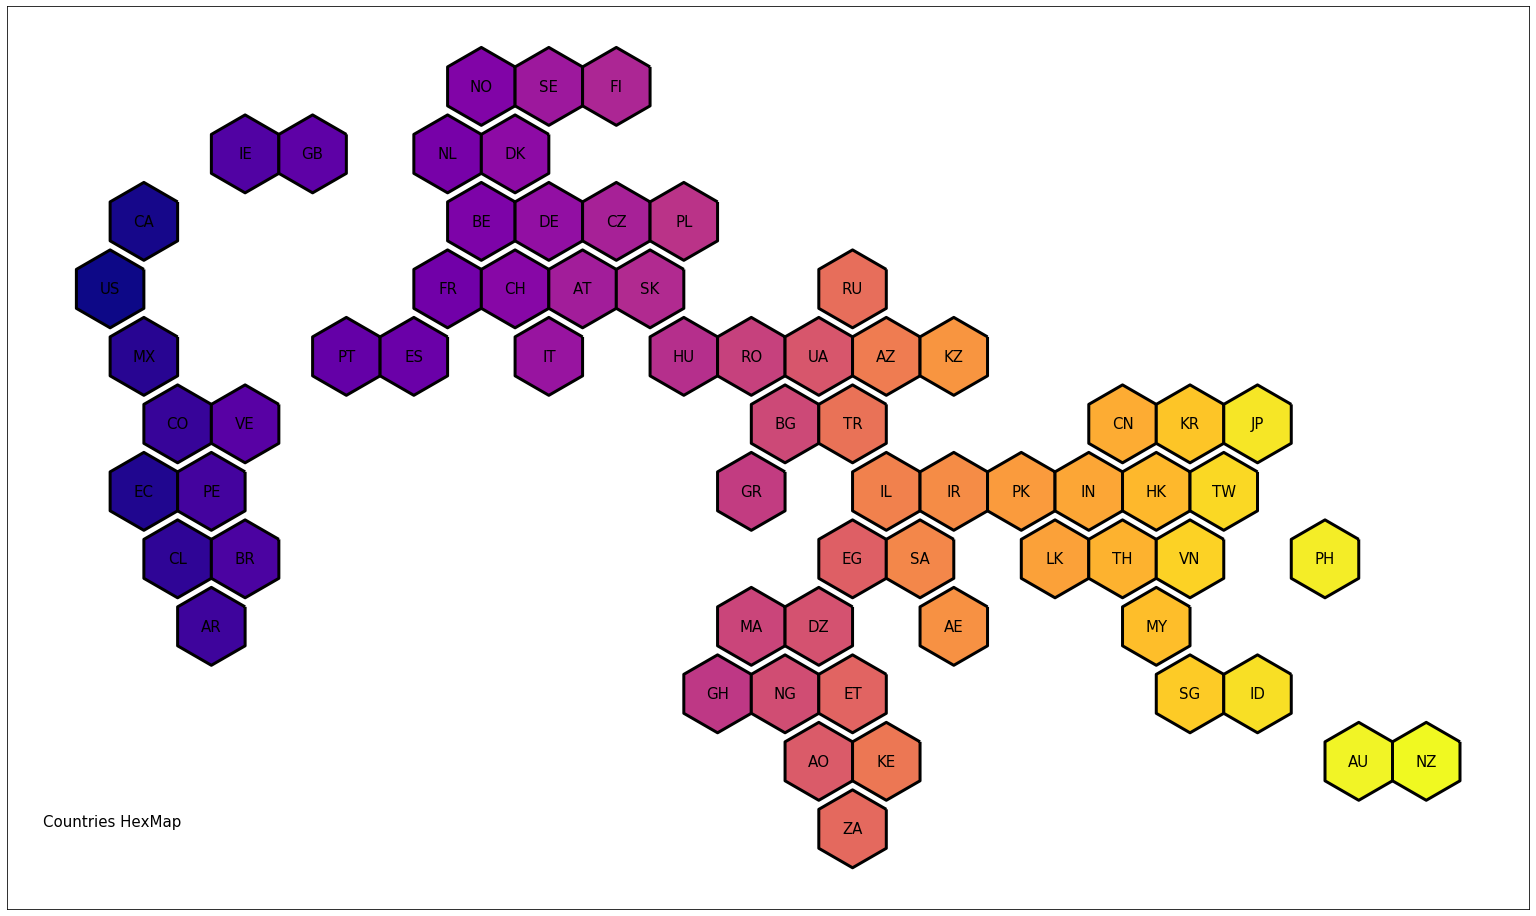

In [18]:
column = None
world_hex = create_hex_grid(hexcodes)
world_hex_path = save_geojson(world_hex, "new_output.geojson")
show_hexgrid(world_hex_path, "plasma", column)

## Enter the file name you want to combine with the HexCodes:
---
*Note: Don't include quotes in the file name.*

In [21]:
file_list = list(
    set(os.listdir(input_directory)) - set(["hexcodes_expanded.csv"]))
file_name = ""
if file_list:
    file_name = input(
        "Enter the file name you want to combine - \nOptions: {}".format(
        file_list))
    print("Reading {}...".format(file_name))
else:
    print("No data file to integrate! \nPlease upload a file in the Input folder and try again.")

No data file to integrate! 
Please upload a file in the Input folder and try again.


## Create a DataFrame from the selected file from Google Drive.
---

In [22]:
data_df = get_data_df(file_name)

Input is not a file


## Combine HexCodes with the input data file.
---

In [0]:
if not data_df.empty:
    hexcode_df = hexcodes.set_index("id")
    combi_df = hexcode_df.join(data_df, how="inner")
    combi_df.reset_index(inplace=True)
    combi_df.rename(columns={'index': 'id'}, inplace=True)
    combi_df.dropna(how="all", axis=1, inplace=True)
    combi_df.fillna('', inplace=True)

## Clean the DataFrame
---
*gets rid of duplicates and empty columns.*

In [0]:
if not data_df.empty:
    combi_new_df = combi_df.T.drop_duplicates().T

## Read the name of the column required to display on the plot:
---
*Note: Don't include quotes in the column name.*

In [0]:
if not data_df.empty:
    column = prompt_column(combi_new_df)

## Create a filtered data-set on the column defined above.
---
*Criteria: filters values of the column in the range of **x**.*

In [0]:
if not data_df.empty:
    combi_x_min = combi_new_df["x"].min()
    combi_x_max = combi_new_df["x"].max()
    filter_condition = combi_new_df[column].ge(combi_x_min) & \
                       combi_new_df[column].le(combi_x_max)
    subset_df = combi_new_df[filter_condition]

## Read the colormap values:
---
*Note: Don't include quotes in the colormap names.*

In [0]:
if not data_df.empty:
    colormap = input(
        "Enter the file name you want to combine - \nOptions: {}".format(
        plt.colormaps()))

## Create the visualization of the data:
---

In [0]:
if not data_df.empty:
    if not subset_df.empty:
        combi_hex = create_hex_grid(subset_df)
        out_file = save_geojson(combi_hex, "combi_hex.geojson")
        show_hexgrid(out_file, colormap, column)
    else:
        print("No data found in this range. Plotting for all values:")
        combi_hex = create_hex_grid(combi_new_df)
        out_file = save_geojson(combi_hex, "combi_hex.geojson")
        show_hexgrid(out_file, colormap, column)